# Project #2 : Continuous Control

## DDPG Training Algorithm

---

This notebook implements my solution for the Continous Control project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

I implemented the Deep Deterministic Policy Gradient (DDPG) training algorithm for the Unity Reacher environment.

The code in this notebook (Continuous_Control.ipynb), the ddpg_agent.py, and model.py files is derived from the 'ddpg-pendulum' code example used in the nanodegree program. The code was modified to successfully train both the single agent and multiple agents version of the the Unity Reacher environment. The code also implements the logic to stop the training when the environment is considered solved. The project requirement is to reach an average score of 30, measured over the last 100 training episodes. In the case of the multiple agents version, the episode score is the mean of the agents' scores of the episode.

### 1. Install Python Packages

If you haven't done so already, run this command to install a few packages in your computing environment.  This line may take a few minutes to run!

In [1]:
#!pip -q install ./python

### 2. Import libraries

In [2]:
import torch
import numpy as np
from collections import deque
#import random
import time

from unityagents import UnityEnvironment

### 3. Instantiate the Unity Reacher environment

**_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [3]:
# on my iMac 
env = UnityEnvironment(file_name="Reacher.app")

# in my Udacity Workspace
#env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

# on my AWS instance
#env = UnityEnvironment(file_name='./Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment and activate the training mode
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents    :', num_agents)

# action size
action_size = brain.vector_action_space_size
print('Size of each action : ', action_size)

# state size
states = env_info.vector_observations
state_size = states.shape[1]
print('Size of each state  :', state_size)

Number of agents    : 20
Size of each action :  4
Size of each state  : 33


### 4. Instantiate the Agent

In [5]:
from ddpg_agent import DDPG_Agent
agent = DDPG_Agent(state_size, action_size, num_agents)


   *****************
   *** Using CPU ***
   *****************



### 5. Train the Agent

In [6]:
# training parameters
n_episodes = 5000   # maximum number of episodes
max_t = 1000        # maximum number of timesteps per episode
target_score = 30   # target score; training is complete when target score is met
window_size = 100   # number of episodes over which the average episode score is calculated
print_every = 10    # number of episodes after which the training procedures prints out a persistent update
    
# variables to track progress of the training process
scores_deque = deque(maxlen = window_size) # deque for the last window_size episode scores
scores = []                                # container for all episode scores
best_score = -np.Inf                       # the highest episode score achieved
start_time =  time.time()                  # start time, required to calculate the total training time

# training loop
for i_episode in range(1, n_episodes+1):

    # reset the environment and obtain the initial state
    env_info = env.reset(train_mode=True)[brain_name]
    states = env_info.vector_observations

    # reset the agent
    agent.reset()

    # reset the score for each Reacher agent
    agent_scores = np.zeros(num_agents)

    # run an experience, one on each Reacher agent
    for t in range(max_t):
        
        # send state to each agent and collect their action
        actions = agent.act(states)

        # send actions to the environments
        env_info = env.step(actions)[brain_name]

        # get next states
        next_states = env_info.vector_observations

        # get rewards
        rewards = env_info.rewards

        # get dones (True if agent reached the terminal state)
        dones = env_info.local_done

        # Save experiences in the replay memory,
        # and sample a batch of experiences from the replay memory to train the agent
        agent.step(states, actions, rewards, next_states, dones)
        #agent.step(states=states, actions=actions, rewards=rewards, next_states=next_states, dones=dones)

        # update the episode score and roll the states over for the next time step
        agent_scores += np.array(rewards)
        states = next_states

        if np.any(dones):
            break

    # calculate the average episode score across all agent
    episode_score = np.mean(agent_scores)

    # update the sliding window of episode scores
    scores_deque.append(episode_score)

    # append the average episode score to the scores array 
    scores.append(episode_score)

    # update the average sliding score
    average_score = np.mean(scores_deque)

    # update time the training process has lasted thus far, in minutes
    total_training_time = time.time() - start_time

    # after each episode, update the printout of the episode and sliding average scores
    print('\rEpisode {}\tScore: {:.1f}\tAverage Score: {:.1f}\tClock: {}'
        .format(i_episode, episode_score, np.mean(scores_deque), int(total_training_time)), end="")

    # after every print_every episode, print the sliding average score
    if i_episode % print_every == 0:
        print('\rEpisode {}\tScore: {:.1f}\t Average Score: {:.1f}\tClock: {}'
        .format(i_episode, episode_score, np.mean(scores_deque), int(total_training_time)))

    # save the model weights if the average episode score improved
    if (i_episode >= window_size) and (episode_score > best_score):
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        best_score = episode_score

    if average_score >= target_score:
        print('\n\nThe agent trained in {:d} episodes! \n\n\tHighest score\t{:.0f}\n\tAverage score\t{:.1f} (measured over last {:d} episodes)\n'
              .format(i_episode - window_size, best_score, average_score, window_size))
        break

Episode 10	Score: 0.7	 Average Score: 0.5	Clock: 209
Episode 20	Score: 1.1	 Average Score: 0.7	Clock: 452
Episode 30	Score: 0.8	 Average Score: 0.8	Clock: 751
Episode 40	Score: 3.0	 Average Score: 1.1	Clock: 1110
Episode 50	Score: 5.5	 Average Score: 1.8	Clock: 1528
Episode 60	Score: 7.6	 Average Score: 2.5	Clock: 1976
Episode 70	Score: 7.9	 Average Score: 3.3	Clock: 2420
Episode 80	Score: 8.5	 Average Score: 4.0	Clock: 2863
Episode 90	Score: 9.6	 Average Score: 4.6	Clock: 3312
Episode 100	Score: 10.3	 Average Score: 5.1	Clock: 3781
Episode 110	Score: 11.2	 Average Score: 6.2	Clock: 4242
Episode 120	Score: 13.5	 Average Score: 7.4	Clock: 4697
Episode 130	Score: 14.3	 Average Score: 8.8	Clock: 5148
Episode 140	Score: 18.0	 Average Score: 10.2	Clock: 5594
Episode 150	Score: 18.8	 Average Score: 11.5	Clock: 6040
Episode 160	Score: 18.3	 Average Score: 12.6	Clock: 6489
Episode 170	Score: 19.9	 Average Score: 13.9	Clock: 6934
Episode 180	Score: 23.3	 Average Score: 15.2	Clock: 7387
Episode 

In [7]:
env.close()

### 6. Plot and save the Training Curve

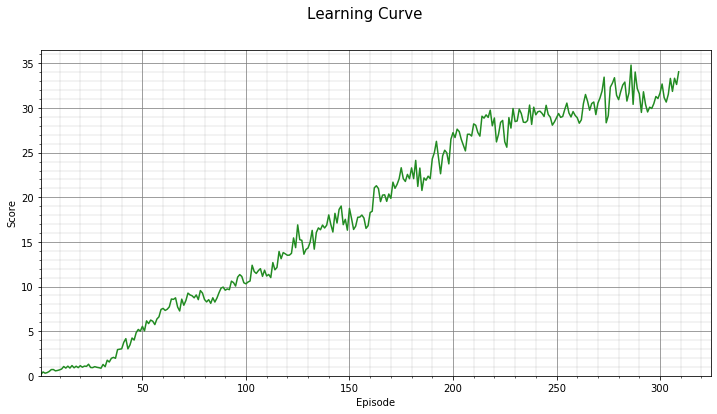

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(12, 6))
fig.suptitle("Learning Curve", fontsize=15)
ax.plot(np.arange(1, len(scores)+1), scores, color="forestgreen", label="line")
plt.xlim(left=1)
plt.ylim(bottom=0)
ax.set_xlabel("Episode")
ax.set_ylabel("Score")
ax.grid(True)
ax.grid(b=True, which='major', color='gray', linestyle='-', linewidth=0.75)
ax.minorticks_on()
ax.grid(b=True, which='minor', color='gray', linestyle='-', alpha=.75, linewidth=0.25)
plt.show()

#  save plot to a file
fig.savefig("ddpg_agent_learning_curve.jpg")